In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfinv
import scipy.integrate
from iminuit import Minuit


In [2]:
#problem 1



#Define class to model background distribution
class Linear:
    def __init__(self,intercept,slope,XMIN, XMAX):
        self.mass= []                              #mass array attribute
        self.intercept = intercept          
        self.slope = slope
        self.XMIN = XMIN 
        self.XMAX = XMAX
    
    #Method that evalutates linear function
    def evaluate (self,t):
        return self.intercept + self.slope * t        #linear equation
    
    #Method to calculate maximum y value of linear distribution
    def maxval(self):
        return self.evaluate(self.XMIN)            #since gradient is negative, max y value is at the minimum x value
    
    #Method to integrate function between parameters a and b
    def integral(self,a,b):
        return scipy.integrate.quad(self.evaluate,a,b)
    
    #next method draws random sample from linear distribution using box method
    def next(self):
        doLoop = True
        while(doLoop):
            #  
            t = np.random.uniform(self.XMIN,self.XMAX)   #Generate random x between xmin and xmax
            y1 = self.evaluate(t)                        #call evaluate method to calculate corresponding y value from linear function
            y2 = np.random.uniform(0 ,self.maxval())     #create y2 value between 0 and max value in linear distribution
            if y2 < y1:
                filtered_x = t
                self.mass.append(filtered_x)             #append mass to mass array
                return filtered_x

#Define class to model signal distribution          
class Gaussian():
    def __init__(self,mean,sigma):
        self.mass_sig = []
        self.mean = mean
        self.sigma = sigma
        self.mass = []
    
    #Method that evalutates Gaussian function
    def evaluate(self,x):
        return 1/(self.sigma*np.sqrt(2*np.pi))*np.exp((-1/2)*((x-self.mean)/self.sigma)**2)  #Equation for gaussian
    
    #Method to integrate function between parameters a and b
    def integral(self,a,b):
        return scipy.integrate.quad(self.evaluate,a,b)
        
    #Method to calculate maximum y value of gaussian distribution
    def maxval(self):
        return self.evaluate(self.mean)                 #We know that the maximum of a Gaussian is at the mean value of x
    
    def next(self):  
        return np.random.normal(self.mean,self.sigma)   #return random sample taken from Gaussian distriution
       
#Class that will return the sum of the backround and the signal distributions       
class SignalWithBackground():
    def __init__(self,mean,sigma,sig_fraction,intercept,slope,XMIN, XMAX):
        self.mean = mean
        self.sigma = sigma
        self.sig_fraction = sig_fraction
        self.intercept = intercept
        self.slope = slope
        self.XMIN = XMIN
        self.XMAX = XMAX
        self.mass_sig = []
        self.mass_bgd = []
        self.mass = []
        self.linear = Linear(intercept,slope,XMIN,XMAX)
        self.gaussian = Gaussian(mean,sigma)
        
    def next(self):
        q =np.random.uniform ()                    #Generate random float in [0,1] to weight signal and background events
        
        #If statement means that we get a background event if the random float q is less than the signal fraction
        #This weights the signal and background signals based on the sig_fraction variable which is related to the number 
        #of signal events compared to background events
        if(q < self.sig_fraction ):
            # draw x from signal distribution
            filtered_x = self.gaussian.next()
            self.mass_sig.append(filtered_x)        #append to mass_sig array
        else:
            # draw x from background distribuion
            filtered_x = self.linear.next()
            self.mass_bgd.append(filtered_x)         #append to mass_bgd array
          
        self.mass.append(filtered_x)
        return filtered_x

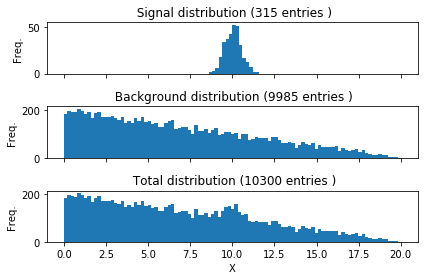

In [3]:

# Generate and plot a single experiment
def singleToy ( nevents_sig = 300 , nevents_bgd = 10000):
    sig_fraction = nevents_sig /( nevents_bgd + nevents_sig )  #calculates weighting for signal and background.
    # Create the pdf
    
    # background parameters
    XMIN = 0
    XMAX = 20
    intercept = 20
    slope = -1
    # signal parameters
    mean = 10
    sigma = 0.5
    
    NBINS =100
    #create pdf object
    pdf = SignalWithBackground(mean,sigma,sig_fraction,intercept,slope,XMIN, XMAX )
    
    #add masses for every event
    for i in range ( nevents_sig + nevents_bgd ): pdf.next()
        
    # retrieve the mass values for signal , background and their sum
    data = pdf.mass
    sig_data = pdf.mass_sig
    bgd_data = pdf.mass_bgd
    
    # plot distributions
    myRange = (XMIN,XMAX)
    fig , axs = plt.subplots (3 ,1 , sharex ='col')
    axs [0].set_title(" Signal distribution (" + str( len( sig_data )) + " entries )")
    axs [1].set_title(" Background distribution (" + str( len ( bgd_data )) + " entries )")
    axs [2].set_title(" Total distribution (" + str ( len ( data )) + " entries )")
    axs [2].set_xlabel('X')
    axs [0].set_ylabel('Freq.')
    axs [1].set_ylabel('Freq.')
    axs [2].set_ylabel('Freq.')
    
    axs [0].hist(sig_data,bins=NBINS,range = myRange)
    axs [1].hist(bgd_data,bins=NBINS )
    axs [2].hist(data,bins = NBINS )
    fig.tight_layout()
    plt.savefig ('Example1.pdf')
    
singleToy()

In [4]:
#Q2

#create Gaussian object with mean = 1000 and sigma = 100 
#call integral method to integrate Gaussian from [0,10300]
prob = Gaussian(mean = 10000, sigma = 100).integral(0,10300)

#We want p-value for k >= 10300. This is 1 - (the integral of pdf from [0,10300])
#This is because total integral under pdf = 1

pvalue = 1-prob[0]
print("The p value is ",pvalue)

#Inverse error function to calculate z score.
n_sigmas = erfinv (1 - pvalue ) *np.sqrt(2)
print("The Z-score is ", n_sigmas)




The p value is  0.0013498980316304365
The Z-score is  3.2051549205988596


In [5]:
#Q3

#Call integrate method in Linear class to integrate in interval [5,15]
sub_bkg = Linear(intercept=20,slope=-1,XMIN=0, XMAX=20).integral(5,15)

#Call integrate method in Linear class to integrate in interval [0,20]
bkg_total = Linear(intercept=20,slope=-1,XMIN=0, XMAX=20).integral(0,20)

#Calculate ration of integrals to give percentage of events lying in subregion
print('% of events in subregion is: ', sub_bkg[0]*100/bkg_total[0],'%') 


#create Gaussian object with mean = 5000 and sigma = sqr root(5000) 
#call integral method to integrate Gaussian from [0,5300]
prob = Gaussian(mean = 5000, sigma = np.sqrt(5000)).integral(0,5300)
pvalue = 1-prob[0]
print("The p value is ",pvalue)

n_sigmas = erfinv (1 - pvalue ) *np.sqrt(2)
print("The Z-score is ", n_sigmas)

#The deviation is more significant in this case because this is the region in 
#which the signal peak lies so the signal events make up a larger % of the 
#total number of events in this region. This means it is even more unlikely we 
#would observe this trend if we accept the null hypothesis (no signal) so
#therefore the p value is lower. 

% of events in subregion is:  50.0 %
The p value is  1.1045248498708915e-05
The Z-score is  4.395628921098688


In [6]:
#Q4

import scipy.stats as stats

# background parameters
XMIN = 0
XMAX = 20
intercept = 20
slope = -1
# signal parameters
mean = 10
sigma = 0.5
# chose number of bins that is appropriate for the size of the statistics sample
NBINS = 100

#Decreasing population of signal events to 150 
nevents_sig = 150 
nevents_bgd = 10000
total_events = nevents_sig + nevents_bgd

sig_fraction = nevents_sig /( nevents_bgd + nevents_sig )

#create pdf object of SignalWithBackgroundd class
pdf = SignalWithBackground(mean,sigma,sig_fraction,intercept,slope,XMIN, XMAX )


for i in range(total_events): pdf.next()                 #get mass data for every event
data = np.array(pdf.mass)                                #mass data as an array

#Function to output results from maximum likelihood fit
def showIminuitResult( params, theMinuit ):

    fstr = "{0:8.4f}"
    #For loop that prints value and corresponding error for every parameter
    for pn in params :
        val = theMinuit.values[pn]
        err = theMinuit.errors[pn]
        print('\t','{:15s}'.format(pn), ':  \t', fstr.format(val), ' +/- ', fstr.format(err))
        
    print('\n')

#Function to evaluate data with linear function and normalise
def normed_linear(intercept,slope):
    lin = Linear(intercept,slope,XMIN=0,XMAX=20)
    linfunc = lin.evaluate(data)
    integ = lin.integral(0,20)[0]  #Calculate normalisation factor
    return abs((1/integ)*linfunc)

#function to calculate negative log of the likelihood for normalised linear distribution
def NLLh0(intercept,slope):  
    return -np.sum(np.log(normed_linear(intercept,slope))) 


def run_minim(min_func):
    params = ['intercept','slope']                        #set parameters to be calculated
    #Setting values to start at and estimated errors. 
    startvals = {params[0] : 20,params[1] : -1 }           
    theMinuit = Minuit(NLLh0, **startvals)              #run Minuit optimiser with with NLL function.
    theMinuit.errors=[0.1,0.1]                          #Errors on initial start value
    
    #Nll increases by 0.5 when you go to either side of the minimum by one unit error on the parameter
    theMinuit.errordef=0.5                        #Set errordef to 0.5 since this a log-likelihood function

    #Run the minimisation
    result = theMinuit.migrad()
    return params, theMinuit



#call run_minim function with the parameter NLL 
#The function returns calculated parameters and corresponding errors.
params,theMinuit = run_minim(NLLh0)
    
print ("\nMinuit Results for incorrectly normalised PDF (in microseconds)")
showIminuitResult( params, theMinuit )  #call function that outputs results
    



Minuit Results for incorrectly normalised PDF (in microseconds)
	 intercept       :  	  20.0168  +/-    0.1554
	 slope           :  	  -0.9992  +/-    0.0078




In [7]:
"""
def normed_linear(intercept,slope):
    lin = Linear(intercept,slope,XMIN=0,XMAX=20)
    linfunc = lin.evaluate(data)
    integ = lin.integral(0,20)[0]
    return abs((1/integ)*linfunc)
"""

#function to calculate negative log of the joint likelihood for the linear and gaussian distributions
def NLLh1(intercept,slope,f):  
    lin = Linear(intercept,slope,XMIN=0,XMAX=20)
    linfunc = lin.evaluate(data)
    integ = lin.integral(0,20)[0]
    linear_fn = abs((1/integ)*linfunc)  
    
    gauss = Gaussian(mean = 10,sigma = 0.5)   #call function which returns Gaussian pdf
    gauss_fn = gauss.evaluate(data)
    return -np.sum(np.log((f)*gauss_fn+(1-f)*linear_fn))  #return negative log of joint likelihood    
   
def run_minimh1(min_func): 
    params = ['intercept','slope','f']                              #For combined likelihood need three parameters
    #Setting values to start at and estimated errors. 
    startvals = {params[0] : 20,params[1] : -1, params[2] : 0.015 }         #Expect 1.5% signal events 
    theMinuit = Minuit(NLLh1, **startvals)                   #run Minuit optimiser with with NLL function.
    theMinuit.errors=[0.1,0.1,0.01]                          #Errors on initial start value
    
    #Nll increases by 0.5 when you go to either side of the minimum by one unit error on the parameter
    theMinuit.errordef=0.5                        #Set errordef to 0.5 since this a log-likelihood function

    #Run the minimisation
    result = theMinuit.migrad()
    return params, theMinuit

#call run_minim function with the parameter NLL
#The function returns calculated parameters and corresponding errors.
paramsh1,theMinuith1 = run_minimh1(NLLh1)
    
print ("\nMinuit Results  for correctly normalised PDF (in microseconds)")
showIminuitResult( paramsh1, theMinuith1)  #call function that outputs results


Minuit Results  for correctly normalised PDF (in microseconds)
	 intercept       :  	  20.0167  +/-    0.1545
	 slope           :  	  -0.9992  +/-    0.0077
	 f               :  	   0.0117  +/-    0.0033




In [8]:

#Likelihood ratio test

values = theMinuit.values                                     #Get the minimised parameters from minuit outputs
valuesh1= theMinuith1.values

NLL_linear = NLLh0(values[0],values[1])                       #fit with minimised parameters
NLL_combined = NLLh1(valuesh1[0],valuesh1[1],valuesh1[2])

LR_stat = -2*(NLL_combined- NLL_linear)                       #Calculate the likelihood Chi-Squared test stat

print('Likelihood ratio stat', LR_stat)

#Calculates p value of test stat using 1 degree of freedom 
p_val = stats.chi2.sf(LR_stat,1)                         #1 degree of freedom between the two models.
print('The p-value is:', p_val)

nsigs = erfinv (1 - p_val ) *np.sqrt(2)
print("The Z-score is ", nsigs)

Likelihood ratio stat 13.710675923794042
The p-value is: 0.0002132388745415519
The Z-score is  3.702792989595084


C:\Users\Theo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log
C:\Users\Theo\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Text(0.5, 0, 'Change in Chi^2')

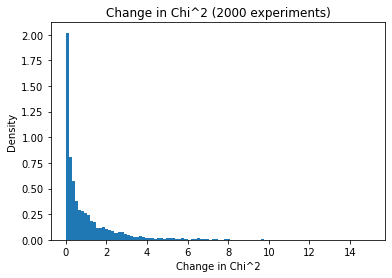

In [9]:
#Bonus Question

nevents_sig = 0
nevents_bgd = 10000
total_events = nevents_sig + nevents_bgd

sig_fraction = 0

LR_stats = []

for j in range(2500):
    pdf = SignalWithBackground(mean,sigma,sig_fraction,intercept,slope,XMIN, XMAX)

    for i in range(total_events): pdf.next()
    data= np.array(pdf.mass)
  
    
    params = ['intercept','slope']                        #set parameters to be calculated
    #Setting values to start at and estimated errors. 
    startvals = {params[0] : 20,params[1] : -1 }           
    theMinuit = Minuit(NLLh0, **startvals)              #run Minuit optimiser with with NLL function.
    theMinuit.errors=[0.1,0.1] 
    theMinuit.errordef = 0.5
    result = theMinuit.migrad()
    values = theMinuit.values
    
    params = ['intercept','slope','f']                              #For combined likelihood need three parameters
    #Setting values to start at and estimated errors. 
    startvals = {params[0] : 20,params[1] : -1, params[2] : 0.015 }         
    theMinuit = Minuit(NLLh1, **startvals)                   #run Minuit optimiser with with NLL function.
    theMinuit.errors=[0.1,0.1,0.01]                          #Errors on initial start value
    
    #Nll increases by 0.5 when you go to either side of the minimum by one unit error on the parameter
    theMinuit.errordef=0.5                        #Set errordef to 0.5 since this a log-likelihood function

    #Run the minimisation
    result = theMinuit.migrad()
    valuesh1= theMinuit.values
    
    
    """"
    params,theMinuit = run_minim(NLLh0)            #Linear fit
    paramsh1,theMinuith1 = run_minimh1(NLLh1)      #combined linear+gaussian fit
    
    values = theMinuit.values                                     #Get the minimised parameters from minuit outputs
    valuesh1= theMinuith1.values
    """
    NLL_linear = NLLh0(values[0],values[1])                     
    NLL_comb = NLLh1(valuesh1[0],valuesh1[1],valuesh1[2])
    LR_stat = -2*(NLL_comb-NLL_linear)                       #Calculate the likelihood Chi-Squared test stat
    LR_stats.append(LR_stat)


plt.hist(LR_stats,bins = 100,range = [0,15],density = True)
plt.title("Change in Chi^2 (2000 experiments)")
plt.ylabel('Density')
plt.xlabel('Change in Chi^2')    

Here I have run the toy MC experiment 2500 with data containing backround events only, but fit to both linear and combined functions H0 and H1. In the Q4 I got a p-value of 2.2*10^-5. This means that there is 2.2*10^(-3)% chance of obtaining results as least as extreme if there is no event signal present. I found the difference of Chi^2 in H0 and H1 in the previous question to be 18, so in theory, 2.2*10^(-3)% of experiemnts should result in a delta chi squared as large as 18. This is very difficult to test accurately since even running the experiment 2500 took a long time to compute, and ideally we would want to test much more than this (hundreds of thousands). However we can see from the histogram that the largest delta chi squared is 9 which is significantly far away from 18. Since the distribution appears to be inverse exponential, it seems highly unlikely to get a delta chi-squared of 18 without doing 50000 tests (in which you would expect one experiment to have at least 18 delta chi-quared). Therefore Wilk's theorem seems consistent with my results.